# Using `zea.Models`: a UNet example

In this notebook, we demonstrate how to use the `zea.Models` interface with a popular deep learning architecture: the UNet. We'll use a pretrained UNet to inpaint missing regions in ultrasound images, and visualize the results. This workflow can be adapted for other tasks and models in the `zea` toolbox.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/models/unet_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/models/unet_example.ipynb)
&nbsp;
[![Hugging Face model](https://img.shields.io/badge/Hugging%20Face-Model-yellow?logo=huggingface)](https://huggingface.co/zeahub/unet-echonet-inpainter)

In [1]:
%%capture
%pip install zea

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
import matplotlib.pyplot as plt
from keras import ops

from zea import init_device, log
from zea.backend.tensorflow.dataloader import make_dataloader
from zea.models.unet import UNet
from zea.models.lpips import LPIPS
from zea.agent.masks import random_uniform_lines
from zea.visualize import plot_image_grid, set_mpl_style

zea: Using backend 'jax'


We will work with the GPU if available, and initialize using `init_device` to pick the best available device. Also, (optionally), we will set the matplotlib style for plotting.

In [4]:
device = init_device(verbose=False)
set_mpl_style()

## Load Data

We load a small batch from the CAMUS validation dataset hosted on Hugging Face Hub.

In [5]:
n_imgs = 8

val_dataset = make_dataloader(
    "hf://zeahub/camus-sample/val",
    key="data/image",
    batch_size=n_imgs,
    shuffle=True,
    image_size=[128, 128],
    resize_type="resize",
    image_range=[-60, 0],
    normalization_range=[-1, 1],
    seed=42,
)
batch = next(iter(val_dataset))
batch = ops.clip(batch, -1, 1)

zea: Using pregenerated dataset info file: /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/dataset_info.yaml ...
zea: ...for reading file paths in /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on September 24, 2025
zea: Remove /root/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.
zea: WARNING H5Generator: Not all files have the same shape. This can lead to issues when resizing images later....
zea: H5Generator: Shuffled data.


I0000 00:00:1758703481.830153   66794 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43494 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:c1:00.0, compute capability: 8.9


zea: H5Generator: Shuffled data.


## Load UNet Model

We use a pretrained UNet model from `zea` for inpainting.

In [6]:
presets = list(UNet.presets.keys())
log.info(f"Available built-in zea presets for UNet: {presets}")

model = UNet.from_preset("unet-echonet-inpainter")

zea: Available built-in zea presets for UNet: ['unet-echonet-inpainter']


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

model.weights.h5:   0%|          | 0.00/23.6M [00:00<?, ?B/s]

## Simulate Missing Data

We simulate missing data by masking out random columns in each image (e.g., 75% missing). This is a common scenario in cognitive ultrasound where some scanlines may be missing (i.e. not acquired) or corrupted.

In [7]:
n_columns = 128  # batch.shape[2]
mask = random_uniform_lines(n_columns // 4, n_columns, n_imgs)
corrupted = batch * ops.cast(mask[:, None, :, None], batch.dtype)

## Inpaint with UNet

We use the UNet to inpaint the missing regions.

In [8]:
inpainted = model(corrupted)
inpainted = ops.clip(inpainted, -1, 1)

## Evaluate Perceptual Similarity

We use the LPIPS metric to evaluate perceptual similarity between the ground truth and inpainted images. For more detailed example of this metric, see [this notebook](../metrics/lpips_example.ipynb).

In [9]:
lpips = LPIPS.from_preset("lpips")
lpips_scores = lpips([inpainted, inpainted])
lpips_scores = ops.convert_to_numpy(lpips_scores)

## Visualization

We plot the ground truth, corrupted, inpainted, and error images. The LPIPS score is shown on each inpainted image. Note that this model was trained on the EchoNet-Dynamic dataset, whereas we are testing now on the CAMUS dataset.

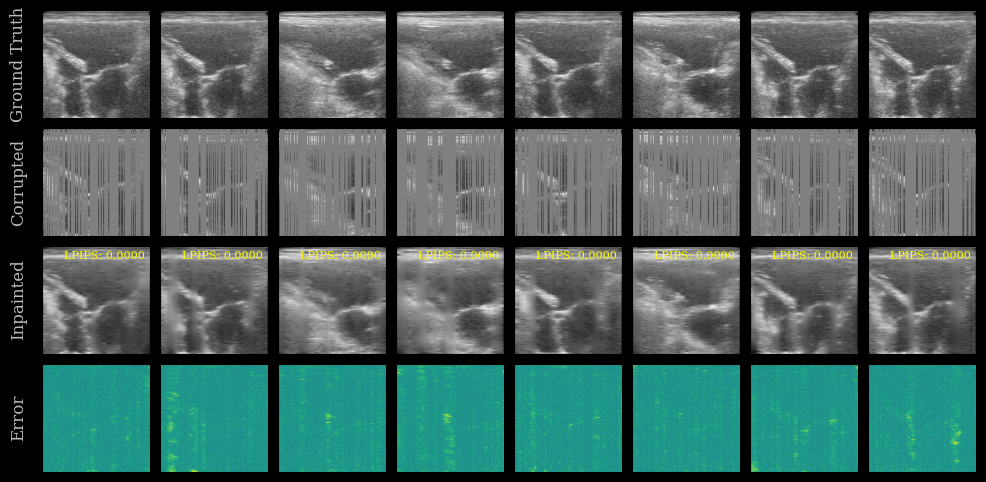

In [10]:
error = ops.abs(batch - inpainted)
imgs = ops.concatenate([batch, corrupted, inpainted, error], axis=0)
imgs = ops.convert_to_numpy(imgs)

cmaps = ["gray"] * (3 * n_imgs) + ["viridis"] * n_imgs

fig, _ = plot_image_grid(
    imgs,
    vmin=-1,
    vmax=1,
    ncols=n_imgs,
    remove_axis=False,
    cmap=cmaps,
    figsize=(n_imgs * 2, 6),
)

titles = ["Ground Truth", "Corrupted", "Inpainted", "Error"]
for i, ax in enumerate(fig.axes[: len(titles) * n_imgs]):
    if i % n_imgs == 0:
        ax.set_ylabel(titles[i // n_imgs])

# Show LPIPS score on each inpainted image
for ax, lpips_score in zip(fig.axes[n_imgs * 2 : 3 * n_imgs], lpips_scores):
    ax.text(
        0.95,
        0.95,
        f"LPIPS: {float(lpips_score):.4f}",
        ha="right",
        va="top",
        transform=ax.transAxes,
        fontsize=8,
        color="yellow",
    )
plt.show()

You can try other UNet presets or experiment with different masking strategies to explore the capabilities of `zea.Models`!